# Expectation Maximization

In this experiment, we implement Expectation-Maximization (EM) algorithmn for a Noisy-OR belief network
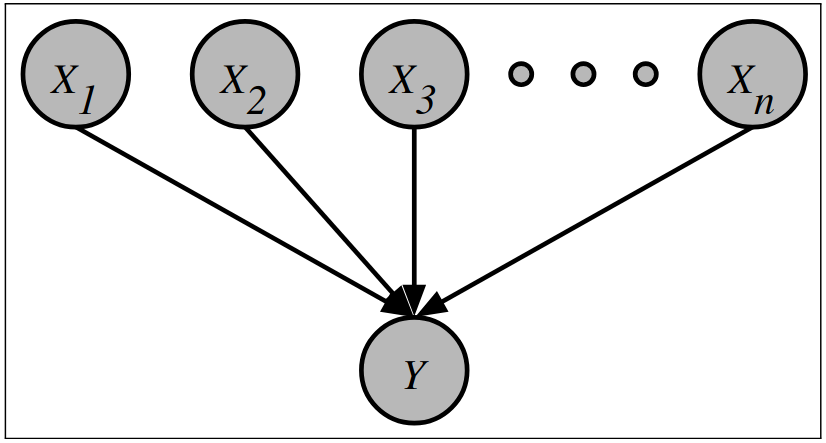

## Noisy-OR
Let $ X \in \{0, 1\}^n $ and $ Y \in \{0, 1\} $ be binary random variables in a belief network.

The noisy-OR conditional probability table (CPT) is defined as:

$$
P(Y = 1 \mid X) = 1 - \prod_{i=1}^n (1 - p_i)^{X_i}
$$

where $ p_i \in [0, 1] $ are the noisy-OR parameters. We can find $p_i$ as the inputs and outputs are observed. We can modify the belief network such that we can introduce latent variables in the network.

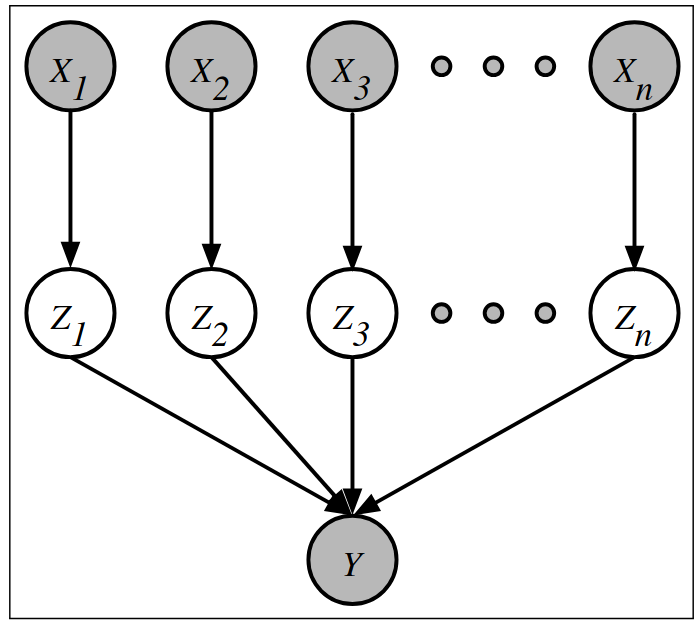

Let $Z_i \in \{0, 1\}$ be a binary random variable interceding between each pair $X_i$ and $Y$. Suppose:

$$
P(Z_i = 1 \mid X_i = 0) = 0, \quad P(Z_i = 1 \mid X_i = 1) = p_i
$$

Also, let the node $Y$ be determined by the logical-OR of the $Z_i$. In other words:

$$
P(Y = 1 \mid Z) =
\begin{cases}
1 & \text{if } Z_i = 1 \text{ for any } i, \\
0 & \text{if } Z_i = 0 \text{ for all } i.
\end{cases}
$$



The new network gives the same CPT as the original network

\begin{aligned}
P(Y|X) & = \sum_{Z \in \{0,1\}^n}P(Y,Z = z|X)\\
& = \sum_{Z \in \{0,1\}^n}P(Y| Z = z)P(Z=z|X)\\
& = \sum_{Z \in \{0,1\}^n} P(Y| Z = z)(\Pi_{i=1}^nP(Z=z_i|X_i))\\
\end{aligned}

From the above network

<div style="display: flex; justify-content: center;">
  <table border="1" cellpadding="8">
  <tr>
   <th>xi/zi  </th><th>0</th><th>1</th>
  </tr>
  <tr>
    <td>0</td><td>1</td><td>0</td>
  </tr>
  <tr>
    <td>1</td><td>1-p_i</td><td>p_i</td>
  </tr>
</table>
</div>

\begin{aligned}
P(z_i|X_i) = (1-z_i)^{1-X_i}((1-p_i)(1-z_i)+p_iz_i)^{X_i}
\end{aligned}

and 

\begin{aligned}
P(Y = 0 \mid Z = z) = 
\begin{cases}
0 & \text{if any } z_i = 1 \\
1 & \text{if all } z_i = 0
\end{cases}
\end{aligned}

Verifying the case of Y = 0, we get
\begin{aligned}
P(Y = 0 | X) & = \Pi_{i=1}^nP(z_i = 0|X_i) \\
& = \Pi_{i=1}^n(1-0)^{1-X_i}(1-p_i)^{X_i} = \Pi_{i=1}^n(1-p_i)^{X_i} \\
\end{aligned}


The EM algorithmn maximizes the log likelihood of the observed data 
$$\mathcal{L} = \frac{1}{T}\sum_{t = 1}^T\log P(Y = y^{(t)} | X = x^{(t)})$$
EM algorithmn consist of two steps **Expectation step** and **Maximization step**. 

The expectation step involves finding the expected value of the log likelihood function of the observed data which needs to be maximized. For that, we need the posterior probability $P(Z_i=1,X_i=1|X=x,Y=y)$. By expanding and simplifying considering $P(x_i|X)=x_i$ and other substitutions based on $x \in \{0,1\}^n$ and $y \in \{0,1\}$ we get
$$P(Z_i=1,X_i=1|X=x,Y=y) = \frac{yx_ip_i}{1-\Pi_j(1-p_j)^{x_j}}$$

The maximization step involves finding the parameter $p_i$ by maximizing the expected likelihood we found above. In this case of noisy OR we get,
$$
p_i \leftarrow \frac{1}{T_i} \sum_{t} P\left(Z_i = 1,\, X_i = 1 \mid X = x^{(t)},\, Y = y^{(t)}\right)
$$
Where $T_i$ is the number of examples in which $X_i=1$. 

If we do second derivative test for the derived maximization parameter, we can observe that it will be negative - showing that EM algorithmn will ensure that it converges.

Using the new belief network, lets estimate the parameters $p_i$ using EM algorithm. The data set has T = 267 examples over n = 23 inputs.

In [201]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import string
import numpy as np
import csv
import matplotlib.pyplot as plt

In [202]:
df_x=pd.read_csv('spectX.txt',sep = ' ',header=None,quoting=csv.QUOTE_NONE)
df_y=pd.read_csv('spectY.txt',names =['Y'])

In [203]:
df_x= df_x.iloc[:, :-1]  # Drop the last column
df_x.columns = df_x.columns+1 # Change the column index of the dataframe
# df_x.X = df_x.X.apply(lambda x: np.fromstring(x, sep=' ', dtype=int))

In [204]:
def EM_algo(df_x,df_y):
    
    P = 0.05*np.ones(df_x.shape[1])
    
    T_count = df_x.sum() # Finding T_i
    
    iteration = np.power(2,8)+1;
    
    log_likelihood =np.zeros(iteration)
    posterior_prob = np.zeros(df_x.shape)
    mistake =np.zeros(iteration)
    prob_likelihood = np.zeros(df_x.shape[0])
    prob_y_1_x = np.zeros(df_x.shape[0])
    
    for i in range(iteration):
        
        # Model evaluation
        for k in range(df_x.shape[0]):
            prob_y_1_x[k] = 1-np.product(np.power(1-P,df_x.iloc[k].values)) #P(Y=1|X)
            prob_likelihood[k] = df_y.iloc[k].values*prob_y_1_x[k]+(1-df_y.iloc[k].values)*(1-prob_y_1_x[k]) # 267x1, If Y=1 then use above value directly, else get the complement
        
        log_likelihood[i] = np.mean(np.log(prob_likelihood)) #1x1
        mistake[i] = np.sum(df_y['Y'].values^(prob_y_1_x>=0.5),dtype=int) #1x1, Getting the model prediction 1 or 0 using probability >=0.5 or not and using XOR to find incorrect prediction.
          
        # Expectation step
        for j in range(df_x.shape[0]):
            prob = 1-np.product(np.power(1-P,df_x.iloc[j].values)) # 1x1
            posterior_prob[j,:] = df_y.iloc[j].values*(df_x.iloc[j].values*P)/(prob) # 267x23
        
        # Maximization step
        P = np.sum(posterior_prob,axis=0)/np.array(T_count) #23x1
        
    index = [0]+[1* 2**i for i in range(9)]
    print(pd.DataFrame({
    'Iteration': index,
    'Number of mistakes M': mistake[index],
    'log likelihood L': log_likelihood[index]}))

In [205]:
EM_algo(df_x,df_y)

   Iteration  Number of mistakes M  log likelihood L
0          0                 175.0         -0.958085
1          1                  56.0         -0.495916
2          2                  43.0         -0.408221
3          4                  42.0         -0.364615
4          8                  44.0         -0.347501
5         16                  40.0         -0.334617
6         32                  37.0         -0.322581
7         64                  37.0         -0.314827
8        128                  36.0         -0.311156
9        256                  36.0         -0.310161
